#!/usr/bin/env python
# coding: utf-8
# # %pip install tensorflow matplotlib seaborn scikit-learn
# C:\Users\happy\Documents\ironhack\Week7\set2\Project2-G2>pylint project2group2cnn.py --disable=E1101,E0611,E0401

# -------------------------------------------------------------------
# Your code has been rated at 10.00/10 (previous run: 6.92/10, +3.08)
"""
Train and evaluate a CNN on CIFAR-10 using transfer learning with MobileNetV2.
Includes preprocessing, model training, evaluation, fine-tuning, and saving.
"""

In [1]:
# Import necessary libraries
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

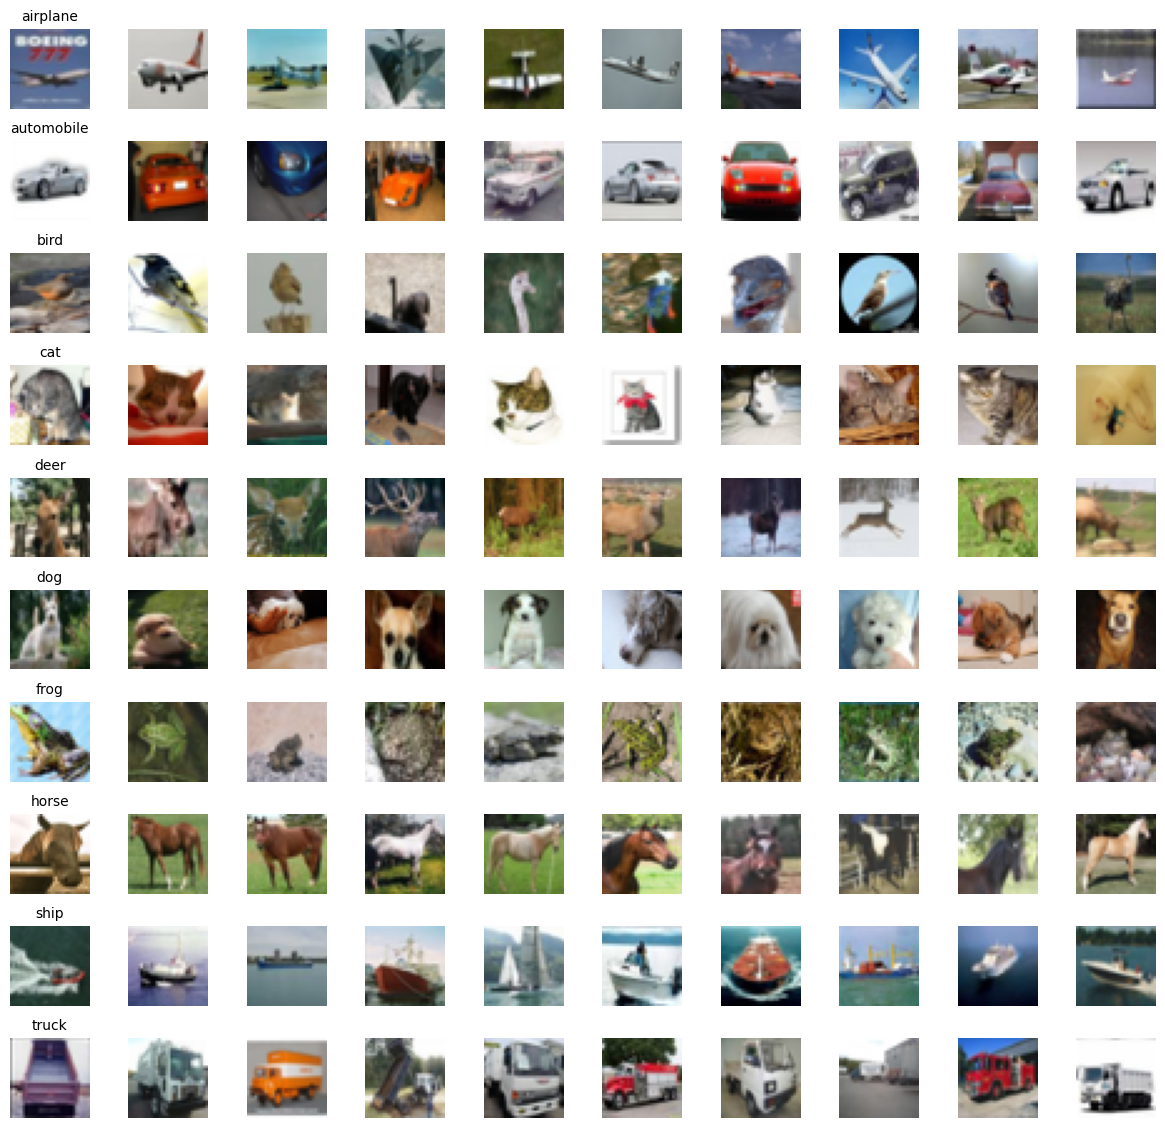

In [4]:
# Visualize sample images
#Plot data
y_labels = np.argmax(y_train_cat, axis=1)

# Plot 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# For each class (0 to 9)
for class_id in range(10):
    # Get all indices of that class
    idxs = np.where(y_labels == class_id)[0]
    # Choose 10 random samples from that class
    selected_idxs = np.random.choice(idxs, 10, replace=False)

    for i in range(10):
        ax = axes[class_id, i]
        ax.imshow(x_train[selected_idxs[i]])
        ax.axis('off')
        if i == 0:
            ax.set_title(class_names[class_id], fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [5]:
#Normalize CIFAR-10 data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [6]:
#Improve generalization through data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [7]:
# CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
y_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [9]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [10]:
# Train the model
# Define callbacks
callbacks = [
    #Stops training if the validation loss doesn’t improve after a set number of epochs.Prevent overfitting.
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
      ),
    #Reduces the learning rate when validation loss stalls.
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, patience=3,
        min_lr=1e-5
      ),
    #Save the best model to disk during training.
    ModelCheckpoint('cnn_optimized_baseline.keras',
        monitor='val_loss',
        save_best_only=True
      )
]

model.fit(datagen.flow(x_train, y_train_cat, batch_size=64),
          validation_data=(x_test, y_test_cat),
          epochs=10,
          callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.3254 - loss: 2.0921 - val_accuracy: 0.4748 - val_loss: 1.4990 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5283 - loss: 1.3089 - val_accuracy: 0.6444 - val_loss: 1.0022 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6072 - loss: 1.1038 - val_accuracy: 0.6284 - val_loss: 1.0453 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.6489 - loss: 1.0100 - val_accuracy: 0.6711 - val_loss: 0.9439 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6657 - loss: 0.9510 - val_accuracy: 0.6828 - val_loss: 0.9152 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6857 - loss: 0.9050 - val_accuracy: 0.6224 - val_loss: 1.2421 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6982 - loss: 0.8645

In [11]:
#Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
model.save('cifar10_CNN_base_model.keras')

In [13]:
#Verify saving
DRIVE_PATH = '/content/'
for item in os.listdir(DRIVE_PATH):
    print(item)

.config
cnn_optimized_baseline.keras
drive
cifar10_CNN_base_model.keras
sample_data


In [14]:
# Evaluate the model on the test set
loss, acc = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7345 - loss: 0.7723
Test Accuracy: 0.7399


In [15]:
# Predict
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [16]:
# Report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.81      0.66      0.73      1000
  automobile       0.88      0.86      0.87      1000
        bird       0.77      0.49      0.60      1000
         cat       0.63      0.50      0.55      1000
        deer       0.70      0.71      0.71      1000
         dog       0.69      0.66      0.67      1000
        frog       0.72      0.88      0.79      1000
       horse       0.72      0.83      0.77      1000
        ship       0.81      0.87      0.84      1000
       truck       0.68      0.94      0.79      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.73     10000
weighted avg       0.74      0.74      0.73     10000



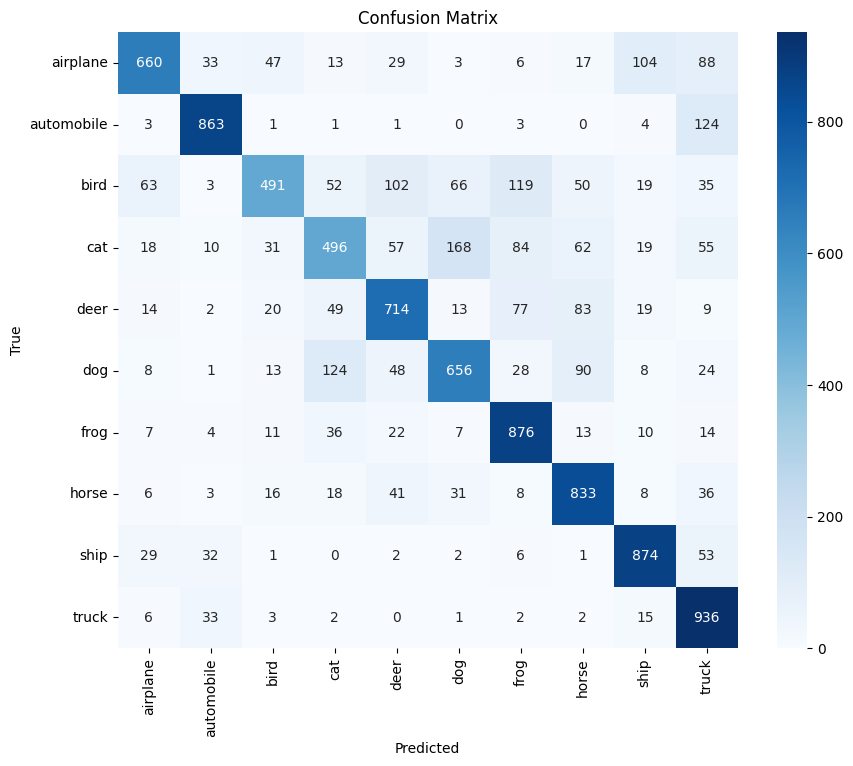

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

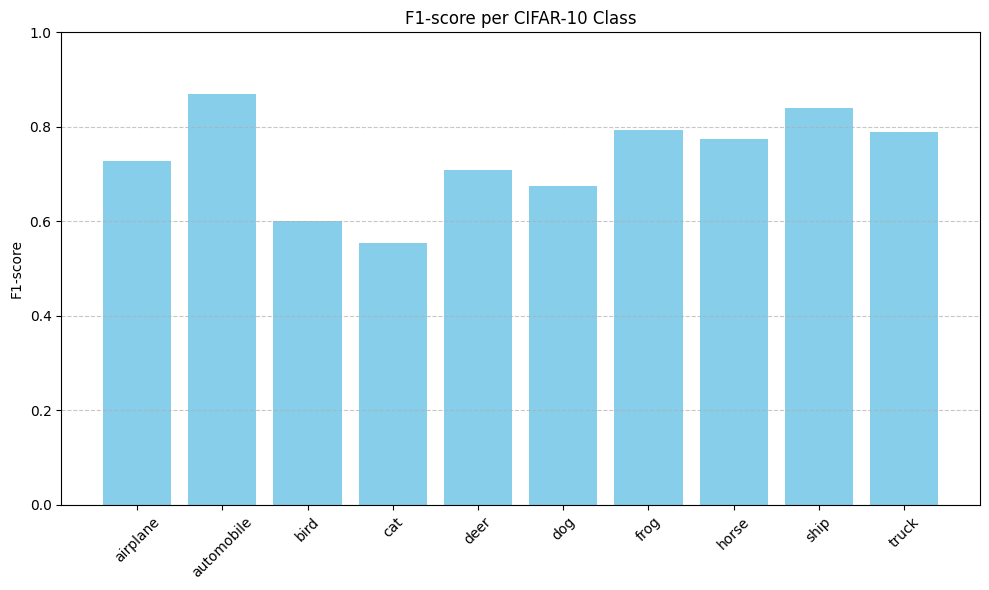

In [18]:
# Parse classification report into dict
report = classification_report(y_true, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'], output_dict=True)

# Extract F1-scores
classes = list(report.keys())[:10]
f1_scores = [report[label]['f1-score'] for label in classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score per CIFAR-10 Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Set image size and batch size
IMG_SIZE = 160
BATCH_SIZE = 32

In [ ]:
# Image preprocessing function
def preprocess(image, name):
    """
    Resize image to target size and normalize pixel values to [0, 1].
    """
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, name

In [ ]:
# Build TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = (
    train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load base MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze base layers

In [ ]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(10, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Print model summary
model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
)

NameError: name 'train_ds' is not defined

In [ ]:
# Evaluate the model on the test set
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0975 - loss: 2.3027
Test Accuracy: 0.1000


In [ ]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step


In [ ]:
# Report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.10      1.00      0.18      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


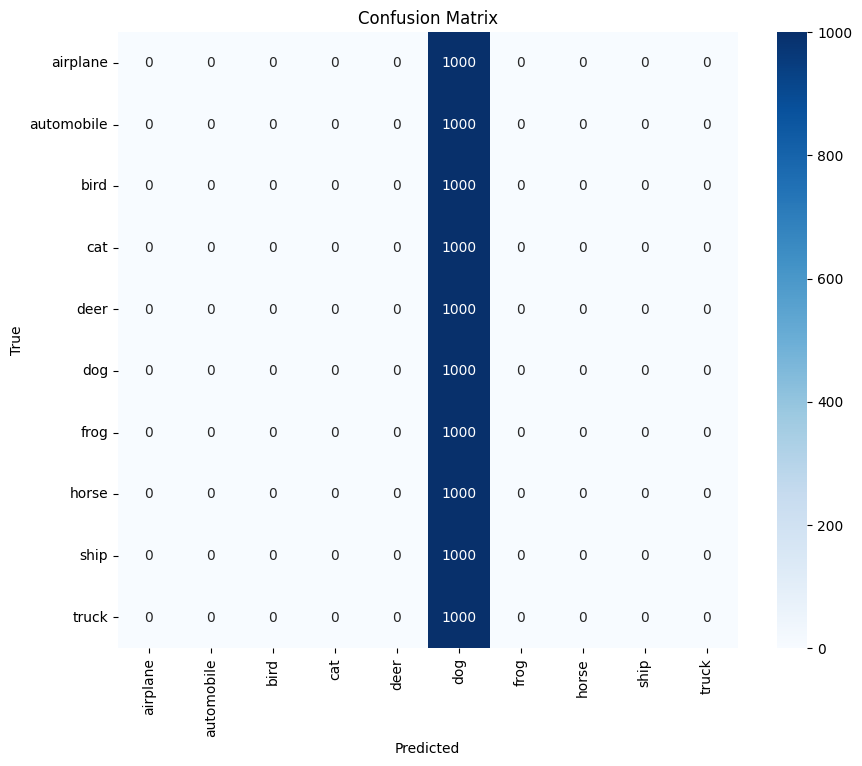

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


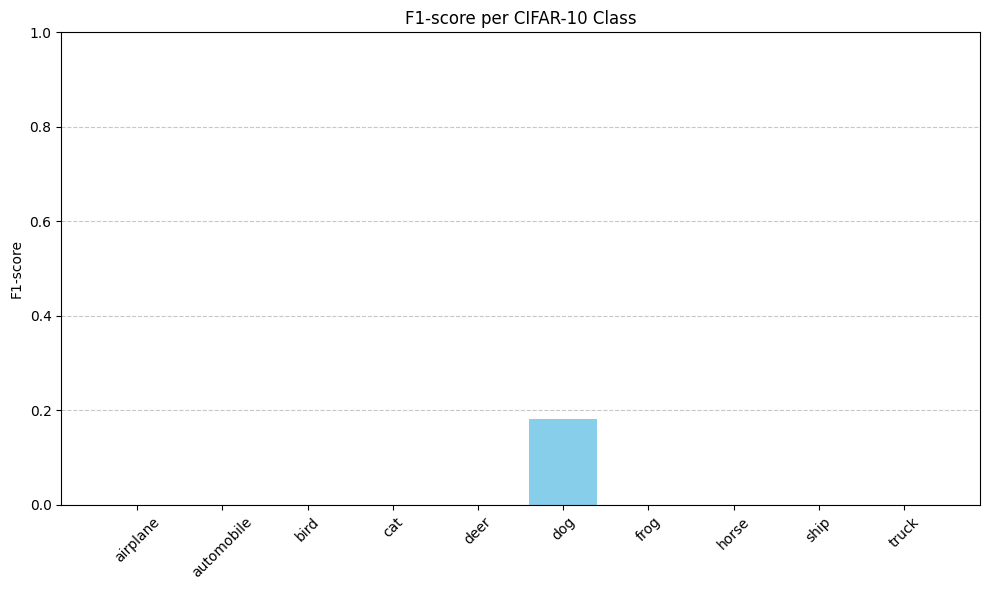

In [ ]:
# Parse classification report into dict
report = classification_report(y_true, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'], output_dict=True)

# Extract F1-scores
classes = list(report.keys())[:10]
f1_scores = [report[label]['f1-score'] for label in classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score per CIFAR-10 Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Path to the model in Google Drive
model_path = '/content/cifar10_CNN_base_model.keras'

# Load the model
model = load_model(model_path)
print("✅ Model loaded successfully from Google Drive!")

✅ Model loaded successfully from Google Drive!


In [ ]:
# # Load CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# class_names = [
#     "airplane",
#     "automobile",
#     "bird",
#     "cat",
#     "deer",
#     "dog",
#     "frog",
#     "horse",
#     "ship",
#     "truck",
# ]
# # One-hot encode labels
# y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
# y_test_cat = tf.keras.utils.to_categorical(y_test, 10)
# #Normalize CIFAR-10 data
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0
#Improve generalization through data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [ ]:
# Unfreeze some layers to fine-tune
for layer in model.layers:
    layer.trainable = True

# Then recompile the model and continue training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Watch validation loss
    factor=0.5,             # Reduce learning rate by 50%
    patience=2,             # Wait 2 epochs before reducing
    min_lr=1e-6,            # Don't go below this learning rate
    verbose=1               # Print updates in training logs
)

from sklearn.utils import class_weight
y_integers = np.argmax(y_train_cat, axis=1)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

class_weights_dict = dict(enumerate(weights))

history = model.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10,
    batch_size=64,
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7799 - loss: 0.6438 - val_accuracy: 0.8142 - val_loss: 0.5409 - learning_rate: 1.0000e-04
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7927 - loss: 0.6073 - val_accuracy: 0.8142 - val_loss: 0.5364 - learning_rate: 1.0000e-04
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7965 - loss: 0.5957 - val_accuracy: 0.8182 - val_loss: 0.5243 - learning_rate: 1.0000e-04
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8030 - loss: 0.5760 - val_accuracy: 0.8195 - val_loss: 0.5205 - learning_rate: 1.0000e-04
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8074 - loss: 0.5569 - val_accuracy: 0.8216 - val_loss: 0.5192 - learning_rate: 1.0000e-04
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8094 - loss: 0.5531 - val_accuracy: 0.8269 - val_loss: 0.5047 - learning_rate: 1.0000e-04
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accur

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8300 - loss: 0.5030
Test Accuracy: 0.8294
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

    airplane       0.83      0.83      0.83      1000
  automobile       0.92      0.92      0.92      1000
        bird       0.81      0.69      0.74      1000
         cat       0.74      0.65      0.69      1000
        deer       0.80      0.81      0.81      1000
         dog       0.74      0.79      0.76      1000
        frog       0.83      0.89      0.86      1000
       horse       0.86      0.87      0.86      1000
        ship       0.90      0.91      0.90      1000
       truck       0.86      0.93      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



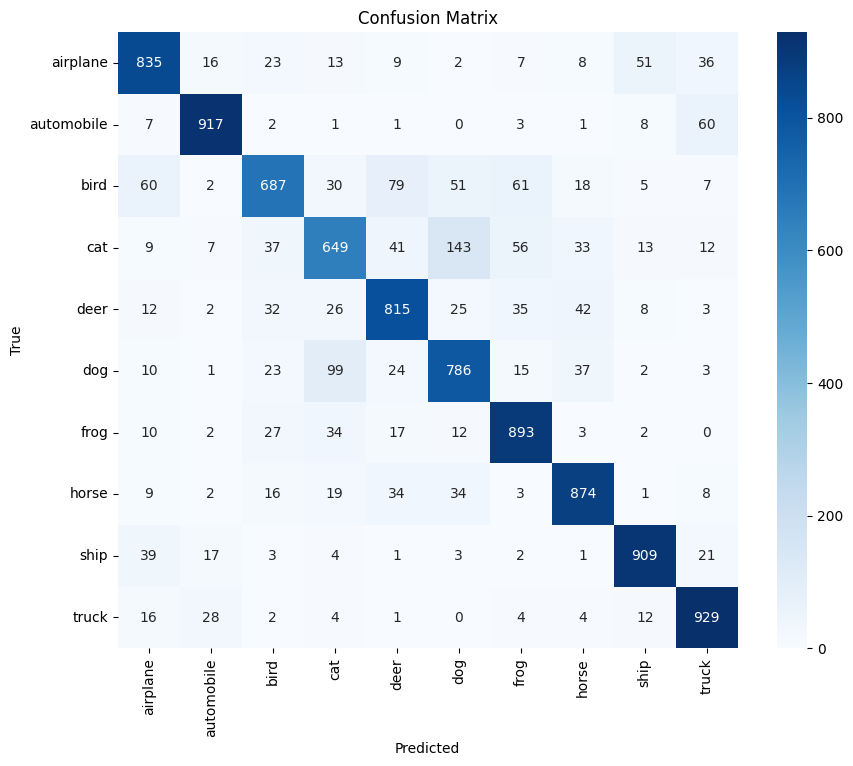

In [ ]:
# Evaluate the model on the test set
loss, acc = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")
# Predict
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
# Report
print(classification_report(y_true, y_pred, target_names=class_names))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

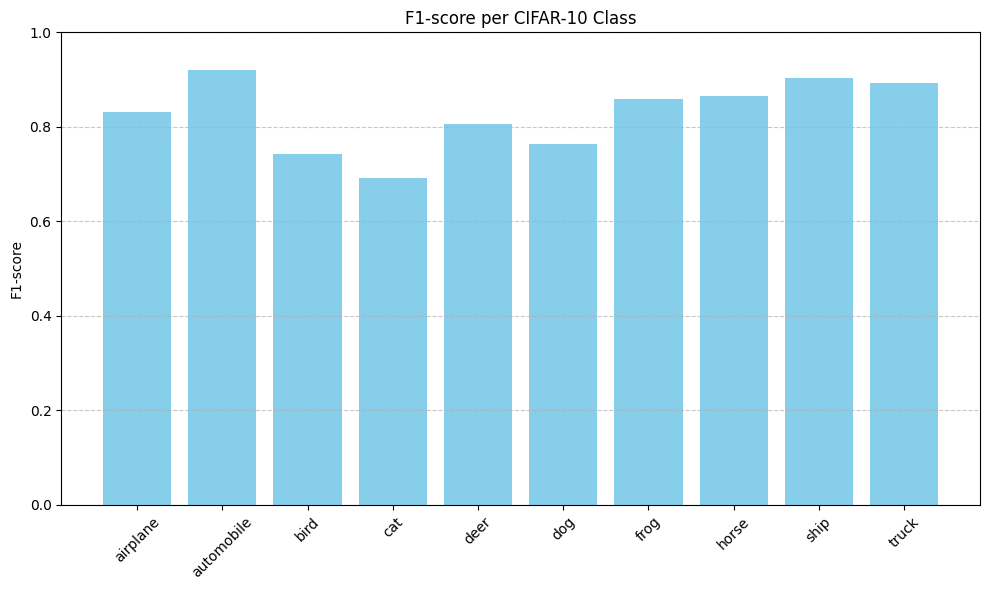

In [ ]:

# Parse classification report into dict
report = classification_report(y_true, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'], output_dict=True)

# Extract F1-scores
classes = list(report.keys())[:10]
f1_scores = [report[label]['f1-score'] for label in classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score per CIFAR-10 Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
model.save("my_finetuned_model.keras")

In [ ]:
from tensorflow.keras.models import load_model

# Path to the model in Google Drive
model_path = '/content/my_finetuned_model.keras'

# Load the model
model = load_model(model_path)
print("✅ Model loaded successfully from Google Drive!")

✅ Model loaded successfully from Google Drive!


In [ ]:
Prepare Data

In [ ]:
IMG_SIZE = 160
x_train_resized = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE))
x_test_resized = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE))


Load MobileNetV2 Base Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze during initial training


Build Transfer Learning Model

In [ ]:
from tensorflow.keras import Model, layers

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)


Compile and Train (Initial Training)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    x_train_resized, y_train_cat,
    validation_data=(x_test_resized, y_test_cat),
    epochs=10,
    batch_size=64
)


Fine-Tuning (Unfreeze Base Model)
After initial training, unfreeze MobileNetV2 and fine-tune:

In [ ]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    x_train_resized, y_train_cat,
    validation_data=(x_test_resized, y_test_cat),
    epochs=10,
    batch_size=64,
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)


In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

# Set image size and batch size
IMG_SIZE = 160
BATCH_SIZE = 32
NUM_CLASSES = 10

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Resize images to 160x160 (MobileNetV2 default input)
x_train_resized = tf.image.resize(x_train, [IMG_SIZE, IMG_SIZE])
x_test_resized = tf.image.resize(x_test, [IMG_SIZE, IMG_SIZE])

# Normalize using preprocess_input for MobileNetV2
x_train_resized = preprocess_input(x_train_resized)
x_test_resized = preprocess_input(x_test_resized)

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Prepare training dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train_resized, y_train_cat))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((x_test_resized, y_test_cat))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load base model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model initially

# Custom classifier head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=base_model.input, outputs=output)

# Compile model
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=Adam(1e-4), loss=loss_fn, metrics=["accuracy"])

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


In [ ]:
import os

# List all files in the current directory
os.listdir('/content')

['.config',
 'cifar10_CNN_base_model.keras',
 'cnn_optimized_baseline.keras',
 'my_finetuned_model.keras',
 'my_finetuned_MobileNetV2_model.keras',
 'drive',
 'sample_data']

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10


In [ ]:
x_train

NameError: name 'x_train' is not defined

In [ ]:
# Resize images from 32x32 to 160x160 (CIFAR-10 → MobileNetV2)
x_train_resized = tf.image.resize(x_train, [160, 160])
x_test_resized = tf.image.resize(x_test, [160, 160])



NameError: name 'tf' is not defined

In [ ]:
x_train_resized

NameError: name 'x_train_resized' is not defined

In [ ]:
# Normalize [0, 255] → [0, 1]
x_train_resized = x_train_resized / 255.0
x_test_resized = x_test_resized / 255.0
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Dataset prep
train_ds = tf.data.Dataset.from_tensor_slices((x_train_resized, y_train_cat))
train_ds = (
    train_ds.map(lambda x, y: (data_augmentation(x), y))
            .shuffle(1000)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_test_resized, y_test_cat))
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


NameError: name 'x_train_resized' is not defined

In [ ]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10

# Normalize and one-hot encode
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Define base model (MobileNetV2) without top layer, input shape adapted for CIFAR-10
base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Initially freeze the layers for transfer learning

# Build model with transfer learning
model = models.Sequential([
    base_model,  # Pre-trained MobileNetV2 (transfer learning)
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Loss function with label smoothing
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights (optional, but helps balance)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.flatten()),
    y=y_train.flatten()
)
class_weights_dict = dict(enumerate(class_weights))

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss_fn,
              metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(x_train)  # Fit the data generator to training data

# Unfreeze the base model layers (MobileNetV2) for fine-tuning
for layer in base_model.layers:
    layer.trainable = True  # Fine-tune all layers of the base model

# Recompile the model before continuing training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss_fn,
              metrics=['accuracy'])

# EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model with transfer learning
history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=64),  # Use augmented data
    validation_data=(x_test, y_test_cat),
    epochs=30,
    callbacks=[lr_scheduler, early_stopping],  # Use learning rate scheduler and early stopping
    class_weight=class_weights_dict
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_cat, verbose=2)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

In [ ]:
# Set image size and batch size
IMG_SIZE = 160
BATCH_SIZE = 32
# Image preprocessing function
def preprocess(image, name):
    """
    Resize image to target size and normalize pixel values to [0, 1].
    """
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, name
    # Build TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = (
    train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:

# Define base model (MobileNetV2) without top layer, input shape adapted for CIFAR-10
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Initially freeze the layers for transfer learning
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(10, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)
# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history = model.fit(
    train_ds,  # Use augmented data
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - accuracy: 0.0977 - loss: 2.3133 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/10
 827/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.0929 - loss: 2.3028

KeyboardInterrupt: 